# Se carga la data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from plotnine import *

In [2]:
df1 = pd.read_csv('data/data_fail.csv')
df=df1.copy(deep=True)
print(df.shape)
df.head()

(5489, 91)


,date,serial_number,model,capacity_bytes,failure,smart_1_normalized,smart_1_raw,smart_2_normalized,smart_2_raw,smart_3_normalized,...,smart_242_normalized,smart_242_raw,smart_250_normalized,smart_250_raw,smart_251_normalized,smart_251_raw,smart_252_normalized,smart_252_raw,smart_254_normalized,smart_254_raw
0,2016-01-01,Z300ZST1,ST4000DM000,1.976651e-311,0,120,240872800,NaN,NaN,91,...,100.0,9.784107e-313,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2016-01-01,9VY8TCAV,ST3160318AS,7.907120e-313,0,111,38605541,NaN,NaN,97,...,100.0,2.076417e-314,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2016-01-01,W300BG0H,ST4000DM000,1.976651e-311,0,118,190147064,NaN,NaN,91,...,100.0,6.394443e-313,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2016-01-01,W300J6FX,ST4000DM000,1.976651e-311,0,115,85258376,NaN,NaN,92,...,100.0,6.040397e-313,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2016-01-01,Z3014A4S,ST4000DM000,1.976651e-311,0,116,101976792,NaN,NaN,91,...,100.0,1.019657e-312,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Intentamos eliminar los registros que tienen NaN alguna de las columnas smart

In [3]:
columnas=df.columns
columnas_raw=[]
for i in columnas:
    l=len(i)
    if i[l-3:]== 'raw':
        columnas_raw.append(i)
columnas_raw.append('smart_9_normalized')
# no eliminamos la columna smart_9_raw,
# ya que esta indica el tiempo de vida del disco
columnas_raw.remove('smart_9_raw')
df=df.rename(columns={'smart_9_raw':'time_day'})
df['time_day']=df['time_day']/24
df = df.drop(columns=columnas_raw, axis=1)


# Registros que fallaron

In [4]:
failed_hdds = df.loc[df.failure==1]["serial_number"]
failed_hdds.describe()

count          214
unique         205
top       Z3015V4D
freq             2
Name: serial_number, dtype: object

In [5]:
fallas=df.loc[df.failure==1]

In [6]:
doble_falla=fallas.groupby("serial_number")['serial_number'].count().sort_values(ascending=False).head(9).index
doble_falla

Index(['Z300GQAF', 'W3006E5B', 'W300J9JA', 'Z300KHN0', 'Z3015V4D',
       'PL1311LAG2B1NH', 'Z300ZSJQ', 'Z300GYM0', 'Z3001J37'],
      dtype='object', name='serial_number')

In [7]:
registros_a_eliminar=[]
for i in doble_falla:
    aux=df['serial_number'].loc[df.serial_number==i][df.failure==1].index
    registros_a_eliminar.append(max(aux))
    print(aux)
print(registros_a_eliminar)

Int64Index([3525, 3649], dtype='int64')
Int64Index([153, 344], dtype='int64')
Int64Index([3415, 3539], dtype='int64')
Int64Index([106, 297], dtype='int64')
Int64Index([121, 312], dtype='int64')
Int64Index([3483, 3607], dtype='int64')
Int64Index([3468, 3592], dtype='int64')
Int64Index([3410, 3534], dtype='int64')
Int64Index([3453, 3577], dtype='int64')
[3649, 344, 3539, 297, 312, 3607, 3592, 3534, 3577]


In [8]:
for i in registros_a_eliminar:
    df=df.drop([i],axis=0)
failed_hdds = df.loc[df.failure==1]["serial_number"]
failed_hdds.describe()

count                205
unique               205
top       PL1301LAG3594H
freq                   1
Name: serial_number, dtype: object

**Eliminamos los registros repetidos de fallas**

## Ahora queda ver si hay itmes registrados mas de una vez en un mismo dia.

In [ ]:
df_date=df.groupby("date",'serial_number')#["date",'serial_number']
doble_ingreso=df_date.groupby('serial_number').count()>1 #.sort_values(ascending=False)#.head(9).index
doble_ingreso.head(5)

In [ ]:
registros_a_eliminar=[]
for i in doble_ingreso:
    aux=df['serial_number'].loc[df.serial_number==i][df.failure==1].index
    registros_a_eliminar.append(max(aux))
    print(aux)
print(registros_a_eliminar)

In [ ]:
for i in registros_a_eliminar:
    df=df.drop([i],axis=0)
failed_hdds = df.loc[df.failure==1]["serial_number"]
failed_hdds.describe()

# Creación de la columna vida_util_restante_int

Es una columna que refleja, cuantos dias de vida le quedan al producto, para que falle. Esto es con el fin de identificar cambios en las variables tipo smart.


In [9]:
#Crear una columna con el dia en que muere el articulo
df["end_date"] = df.groupby("serial_number")["date"].transform("max")

#Tiempo de Vida util articulo(Real)
df['vida_util_days'] = df.groupby("serial_number")["time_day"].transform("max")


#Transformamos a fecha
df["end_date"] = pd.to_datetime(df["end_date"])
df["date"] = pd.to_datetime(df["date"])


#Vida util que le queda al articulo
df["vida_util_restante"] = (df["end_date"] - df["date"])
#Vida util que le queda al articulo (int)
df["vida_util_restante_int"] = (df["vida_util_restante"].astype('int64')/60**2)/24/1000000000.0

#Vida util que le queda al articulo porcentual
#df["vida_util_restante_porcentual"] = (df["vida_util_restante_int"]/df["vida_util_int"])

df_unique = df[df.failure==1]
df.head()


,date,serial_number,model,capacity_bytes,failure,smart_1_normalized,smart_2_normalized,smart_3_normalized,smart_4_normalized,smart_5_normalized,...,smart_241_normalized,smart_242_normalized,smart_250_normalized,smart_251_normalized,smart_252_normalized,smart_254_normalized,end_date,vida_util_days,vida_util_restante,vida_util_restante_int
0,2016-01-01,Z300ZST1,ST4000DM000,1.976651e-311,0,120,NaN,91,100,100,...,100.0,100.0,NaN,NaN,NaN,NaN,2016-01-17,711.166667,16 days,16.0
1,2016-01-01,9VY8TCAV,ST3160318AS,7.907120e-313,0,111,NaN,97,100,100,...,100.0,100.0,NaN,NaN,NaN,NaN,2016-04-09,1953.125000,99 days,99.0
2,2016-01-01,W300BG0H,ST4000DM000,1.976651e-311,0,118,NaN,91,100,100,...,100.0,100.0,NaN,NaN,NaN,NaN,2016-04-18,952.375000,108 days,108.0
3,2016-01-01,W300J6FX,ST4000DM000,1.976651e-311,0,115,NaN,92,100,100,...,100.0,100.0,NaN,NaN,NaN,NaN,2016-04-09,943.666667,99 days,99.0
4,2016-01-01,Z3014A4S,ST4000DM000,1.976651e-311,0,116,NaN,91,100,100,...,100.0,100.0,NaN,NaN,NaN,NaN,2016-01-10,714.000000,9 days,9.0


In [12]:
df["vida_util_days"].describe()

count    5480.000000
mean      864.437181
std       522.790741
min         0.583333
25%       444.291667
50%       839.166667
75%      1150.791667
max      2822.666667
Name: vida_util_days, dtype: float64

In [11]:
df["vida_util_restante"].describe()

count                       5480
mean     49 days 11:28:12.262773
std      44 days 09:03:20.392622
min              0 days 00:00:00
25%              7 days 00:00:00
50%             21 days 12:00:00
75%             95 days 00:00:00
max            119 days 00:00:00
Name: vida_util_restante, dtype: object

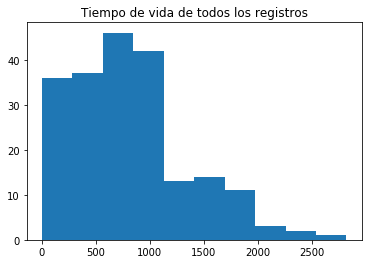

In [13]:
plt.hist(df_unique['vida_util_days'])#, bins=10
plt.title("Tiempo de vida de todos los registros", fontdict=None, loc='center', pad=None,)
plt.show()

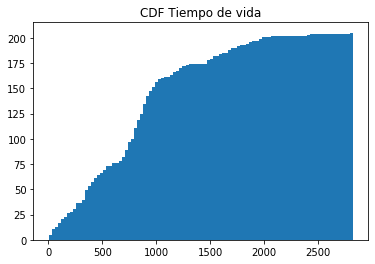

In [14]:
plt.hist(df_unique['vida_util_days'],cumulative=True ,bins=100)#, bins=10
plt.title("CDF Tiempo de vida", fontdict=None, loc='center', pad=None,)
plt.show()

## Comienzo Parte 1 b

In [74]:
df_last_weak    = df[df.vida_util_restante_int<=7]
df_last_2_weaks = df[df.vida_util_restante_int<=14]
df_last_month   = df[df.vida_util_restante_int<=30]

In [75]:
mean_weak = df_last_weak.mean()
std_weak  = df_last_weak.std()
skew_weak = df_last_weak.skew()

In [76]:
mean_2_weaks  = df_last_2_weaks.mean()
std_2_weaks   = df_last_2_weaks.std()
skew_2_weaks  = df_last_2_weaks.skew()

In [77]:
mean_month = df_last_month.mean()
std_month  = df_last_month.std()
skew_month = df_last_month.skew()

In [78]:
d = {}
A=[]
B=[]
C=[]
L=[]
M=[]
N=[]
X=[]
Y=[]
Z=[]
Indices=[]

for i in mean_month.index:
    if i[:5]=='smart':
        indice=list(mean_month.index).index(i)
        Indices.append(i)
        
        A.append(list(mean_weak.values)[indice])
        B.append(list(mean_2_weaks.values)[indice])
        C.append(list(mean_month.values)[indice])
        
        L.append(list(std_weak.values)[indice])
        M.append(list(std_2_weaks.values)[indice])
        N.append(list(std_month.values)[indice])
        
        X.append(list(skew_weak.values)[indice])
        Y.append(list(skew_2_weaks.values)[indice])
        Z.append(list(skew_month.values)[indice])
        
        
d= {'Indices':Indices,'Mean_Weak':A,'Mean_2_Weak':B,'Mean_Month':C,
    'sd_Weak':L,'sd_2_WeakS':M,'sd_Month':N,'skew_Weak':X,
    'skew_2_Weaks':Y,'skew_Month':Z}

## Agregamos el coeficiente de variación

Este valor nos indica la variación de los los valores de las variables SMART, si estas poseen un valor muy bajo de variaciones, su influencia en el modelo es despreciable. Así que eliminaremos todas aquellas que poseean un coeficiente de variación inferior al 1%.

In [79]:
stats_smart=pd.DataFrame.from_dict(d)
stats_smart["Coef_Var_Month"] = ((stats_smart['sd_Month'])/(stats_smart['Mean_Month']))

In [80]:
val_delete=stats_smart[stats_smart.Coef_Var_Month>0.1]
len(val_delete)

15

In [81]:
stats_smart = stats_smart.round(1)
columnas_weak_month = stats_smart.columns
stats_smart_sin_nan = stats_smart.dropna(subset=columnas_weak_month)
lista_smart_sin_nans=list(stats_smart_sin_nan['Indices']) 

In [82]:
for i in lista_smart_sin_nans:
    if i in Indices:
        Indices.remove(i)
for i in Indices:
    del df[i]
    del df_unique[i]

In [83]:
print(stats_smart.Coef_Var_Month.max())
print(stats_smart.Coef_Var_Month.min())

1.0
0.0


In [84]:
print(val_delete.Coef_Var_Month.max())
print(val_delete.Coef_Var_Month.min())

1.0434913066025706
0.10285934529283584


## Resultado de una data, sin variables con coeficiente de variación bajo.

C:\Users\rolft\Anaconda3\lib\site-packages\plotnine\scales\scale.py:93: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cbook.iterable(self.breaks) and cbook.iterable(self.labels):
C:\Users\rolft\Anaconda3\lib\site-packages\plotnine\utils.py:553: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  return cbook.iterable(var) and not is_string(var)


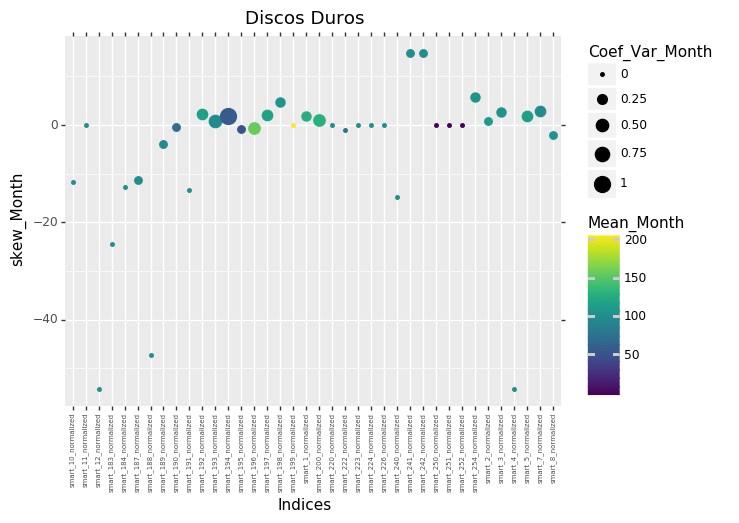

<ggplot: (-9223371894694257888)>

In [57]:
ggplot(stats_smart, aes(x = "Indices", y = "skew_Month",color='Mean_Month',size='Coef_Var_Month'))\
+theme(axis_text_x=element_text(angle=90,size=5))\
+ggtitle("Discos Duros") + geom_point()


C:\Users\rolft\Anaconda3\lib\site-packages\plotnine\scales\scale.py:93: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cbook.iterable(self.breaks) and cbook.iterable(self.labels):
C:\Users\rolft\Anaconda3\lib\site-packages\plotnine\utils.py:553: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  return cbook.iterable(var) and not is_string(var)


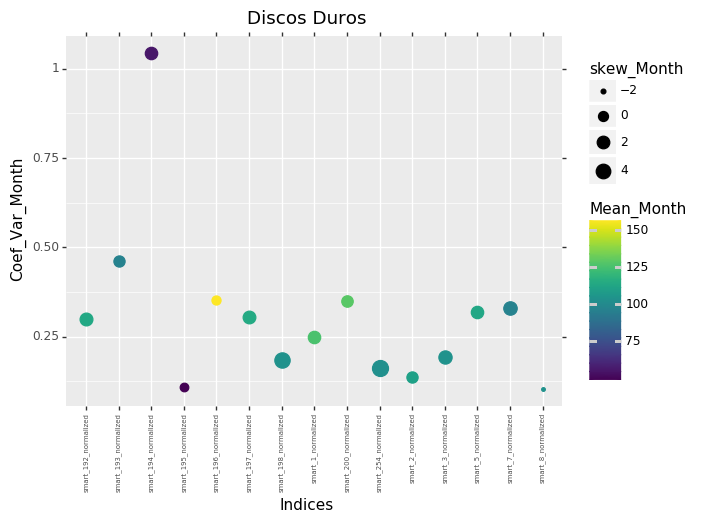

<ggplot: (-9223371894692275838)>

In [85]:
ggplot(val_delete, aes(x = "Indices", y = "Coef_Var_Month",color='Mean_Month',size='skew_Month'))\
+theme(axis_text_x=element_text(angle=90,size=5))\
+ggtitle("Discos Duros") + geom_point()

C:\Users\rolft\Anaconda3\lib\site-packages\plotnine\scales\scale.py:93: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cbook.iterable(self.breaks) and cbook.iterable(self.labels):
C:\Users\rolft\Anaconda3\lib\site-packages\plotnine\utils.py:553: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  return cbook.iterable(var) and not is_string(var)


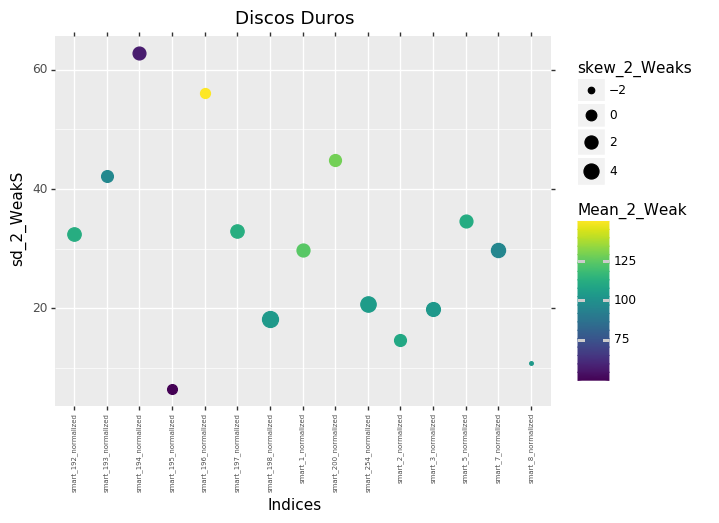

<ggplot: (-9223371894693738759)>

In [86]:
ggplot(val_delete, aes(x = "Indices", y = "sd_2_WeakS",color='Mean_2_Weak',size='skew_2_Weaks'))\
+theme(axis_text_x=element_text(angle=90,size=5))\
+ggtitle("Discos Duros") + geom_point()

C:\Users\rolft\Anaconda3\lib\site-packages\plotnine\scales\scale.py:93: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cbook.iterable(self.breaks) and cbook.iterable(self.labels):
C:\Users\rolft\Anaconda3\lib\site-packages\plotnine\utils.py:553: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  return cbook.iterable(var) and not is_string(var)


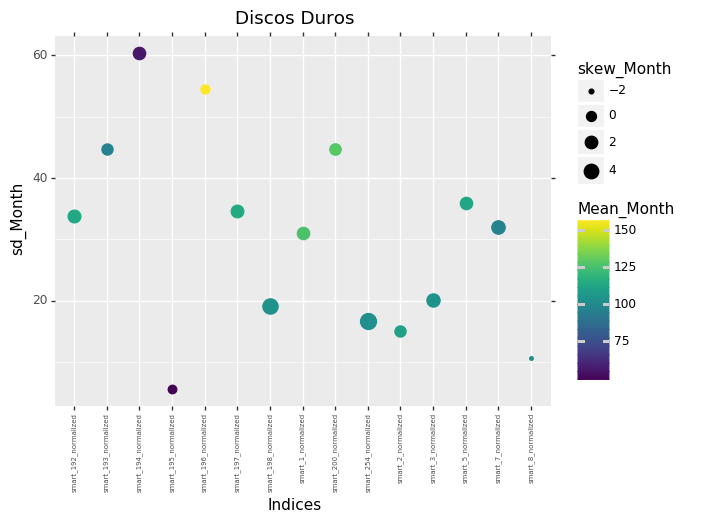

<ggplot: (142160422334)>

In [87]:
ggplot(val_delete, aes(x = "Indices", y = "sd_Month",color='Mean_Month',size='skew_Month'))\
+theme(axis_text_x=element_text(angle=90,size=5))\
+ggtitle("Discos Duros") + geom_point()

In [89]:
val_delete.Indices

0       smart_1_normalized
1       smart_2_normalized
2       smart_3_normalized
4       smart_5_normalized
5       smart_7_normalized
6       smart_8_normalized
17    smart_192_normalized
18    smart_193_normalized
19    smart_194_normalized
20    smart_195_normalized
21    smart_196_normalized
22    smart_197_normalized
23    smart_198_normalized
25    smart_200_normalized
37    smart_254_normalized
Name: Indices, dtype: object

Guardar el p-valor de km, donde se prioriza las variables mas significativas para explicar el comportamiento.

Separar los datos en cuartiles, como lo que se hace en edad.

# Me quedaré solo con las variables smart que poseen una covarianza superior al 10%



In [100]:
list_not_delete=val_delete.Indices


In [112]:
columnas=df.columns
columnas_coef_0_1=[]
for i in columnas:
    l=len(i)
    if i[:5]== 'smart':
        columnas_coef_0_1.append(i)
# no eliminamos la columna smart_9_raw,
# ya que esta indica el tiempo de vida del disco
for j in list_not_delete.index:
    columnas_coef_0_1.remove(list_not_delete.loc[j])
print(columnas_coef_0_1,'Cantidad de columnas a eliminar:', len(columnas_coef_0_1))

['smart_4_normalized', 'smart_10_normalized', 'smart_11_normalized', 'smart_12_normalized', 'smart_183_normalized', 'smart_184_normalized', 'smart_187_normalized', 'smart_188_normalized', 'smart_189_normalized', 'smart_190_normalized', 'smart_191_normalized', 'smart_199_normalized', 'smart_220_normalized', 'smart_222_normalized', 'smart_223_normalized', 'smart_224_normalized', 'smart_226_normalized', 'smart_240_normalized', 'smart_241_normalized', 'smart_242_normalized', 'smart_250_normalized', 'smart_251_normalized', 'smart_252_normalized'] Cantidad de columnas a eliminar: 23


In [113]:
df = df.drop(columns=columnas_coef_0_1, axis=1)

In [114]:
df

,date,serial_number,model,capacity_bytes,failure,smart_1_normalized,smart_2_normalized,smart_3_normalized,smart_5_normalized,smart_7_normalized,...,smart_195_normalized,smart_196_normalized,smart_197_normalized,smart_198_normalized,smart_200_normalized,smart_254_normalized,end_date,vida_util_days,vida_util_restante,vida_util_restante_int
0,2016-01-01,Z300ZST1,ST4000DM000,1.976651e-311,0,120,NaN,91,100,84,...,NaN,NaN,100,100,NaN,NaN,2016-01-17,711.166667,16 days,16.0
1,2016-01-01,9VY8TCAV,ST3160318AS,7.907120e-313,0,111,NaN,97,100,87,...,47.0,NaN,100,100,NaN,NaN,2016-04-09,1953.125000,99 days,99.0
2,2016-01-01,W300BG0H,ST4000DM000,1.976651e-311,0,118,NaN,91,100,87,...,NaN,NaN,100,100,NaN,NaN,2016-04-18,952.375000,108 days,108.0
3,2016-01-01,W300J6FX,ST4000DM000,1.976651e-311,0,115,NaN,92,100,87,...,NaN,NaN,100,100,NaN,NaN,2016-04-09,943.666667,99 days,99.0
4,2016-01-01,Z3014A4S,ST4000DM000,1.976651e-311,0,116,NaN,91,100,84,...,NaN,NaN,100,100,NaN,NaN,2016-01-10,714.000000,9 days,9.0
5,2016-01-01,Z4D045CF,ST6000DX000,2.964974e-311,0,116,NaN,88,100,90,...,66.0,NaN,100,100,NaN,NaN,2016-04-05,606.916667,95 days,95.0
6,2016-01-01,Z4D04BH9,ST6000DX000,2.964974e-311,0,115,NaN,89,100,77,...,65.0,NaN,100,100,NaN,NaN,2016-04-05,370.416667,95 days,95.0
7,2016-01-01,Z3013TQV,ST4000DM000,1.976651e-311,0,108,NaN,91,100,85,...,NaN,NaN,100,100,NaN,NaN,2016-01-11,742.833333,10 days,10.0
8,2016-01-01,WD-WX11D84JN1EP,WDC WD60EFRX,2.964974e-311,0,200,NaN,202,200,100,...,NaN,200.0,200,100,100.0,NaN,2016-01-05,394.875000,4 days,4.0
9,2016-01-01,W0Q26EE1,ST320LT007,1.581370e-312,0,118,NaN,98,100,87,...,51.0,NaN,100,100,NaN,100.0,2016-01-21,877.458333,20 days,20.0


In [115]:
#df.to_csv("data_smart.csv", index = False, sep=',', encoding='utf-8')

# Generar variables dummy para model 

In [ ]:
df.dtypes
df=pd.get_dummies(data, drop_first=True)
df.head()